# Pipeline for analysing open clusters based on Gaia DR2 data

## 1 - Libraries

In [189]:
#%matplotlib notebook

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy
import astropy.stats as ap

from math import pi, ceil, floor
from astropy import units
from astropy.table import Table
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
from IPython.display import display, HTML

#print(scipy.stats.__doc__)
#dir(scipy.stats)

## 2 - Query Gaia DR2 Catalog

In [178]:
# Gaia DR2 catalog on VizieR
# see https://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=I/345/gaia2
cat = 'I/345/gaia2'
cols = ['_r', 'DR2Name', 'RAdeg', 'DEdeg', 'Plx', 'e_Plx', 'pmRA', 'pmDE', 'Gmag', 'BP-G']
filters = {'Plx' : '0..2', 'e_Plx' : '<0.4', 'pmRA' : '-15..15', 'pmDE' : '-15..15', 'Gmag' : '<15.5'}
row_lim = 1000
timeout = 600

#Query the GDR2 data for one cluster
def query(name, ra_deg, de_deg, rad, filter_map, max_stars = 1000):
    print("Querying VizieR for %s ..." % name)
    coo = SkyCoord(ra = ra_deg*units.degree, dec = de_deg*units.degree, frame = 'icrs')
    viz = Vizier(columns = cols, column_filters = filter_map, row_limit = row_lim, timeout = timeout)
    viz_res = viz.query_region(coo, radius = rad*units.degree, catalog = cat)
    if viz_res == None or len(viz_res) == 0:
        print(viz_res)
        return pd.DataFrame() #Empty Dataframe
    df = viz_res[0].to_pandas()
    df = df.set_index('DR2Name')
    df = df.sort_values(by='Gmag')
    df = df[:max_stars]
    df = df.sort_values(by='_r')
    if not df.empty:
        #display(df.head())
        display(df.describe())
    else:
        print('Empty dataframe! - try again with another set of parameters')
    return df

#cl_name, cl_ra, cl_de, radius = 'Alessi_62', 284.026, +21.597, 0.256

cl_name, cl_ra, cl_de, radius = 'HeXuHao 16',  173.095000, -68.090000, 0.210000

df = query(cl_name, cl_ra, cl_de, radius, filters)

Querying VizieR for HeXuHao 16 ...


,_r,_RAJ2000,_DEJ2000,Plx,e_Plx,pmRA,pmDE,Gmag,BP-G
count,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,591.000000
mean,0.138344,173.097359,-68.086156,0.468538,0.030146,-6.884938,1.174216,14.406368,0.628400
std,0.050784,0.279607,0.104171,0.334032,0.024434,3.566360,2.392305,0.996422,0.296142
min,0.012048,172.543910,-68.298631,0.009600,0.014400,-14.935000,-14.183000,8.522700,-0.126800
25%,0.099141,172.877148,-68.166317,0.207300,0.021500,-8.961000,0.304000,13.897700,0.424550
50%,0.147715,173.108328,-68.088274,0.391600,0.026200,-7.102000,1.220000,14.686800,0.576500
75%,0.181191,173.315542,-68.005143,0.653400,0.030800,-5.086000,2.283000,15.168100,0.798250
max,0.209817,173.649831,-67.884932,1.956600,0.294000,13.920000,14.583000,15.494500,2.923100


## 3 - VPD scatter plot and 2D Histogram (returning PMs for the bin with highest count)

HeXuHao 16            ; 173.095000; -68.090000;  0.21000;  0.427; 0.216;  -8.70;  0.70;   1.06;  0.58;  179;  8.52..15.49


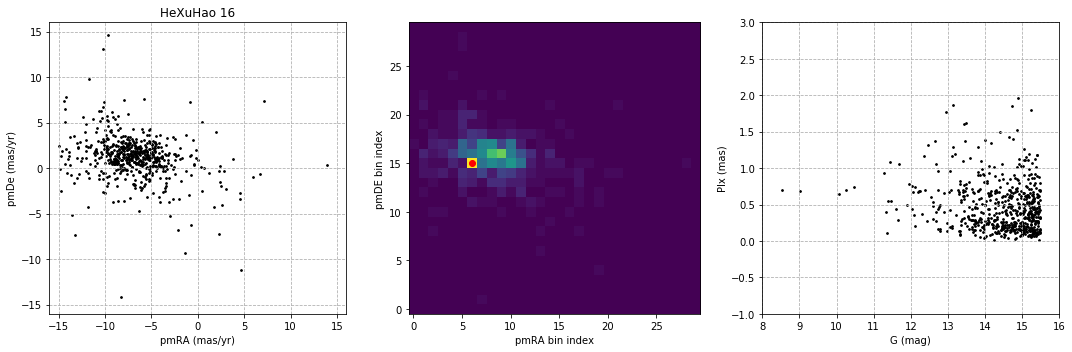

In [181]:
## determine limits for dimensioning the VPD
def pm_limits(pmras, pmdes):
    max_pm = ceil(np.max([np.max(pmras), np.max(pmdes)]) + 1)
    min_pm = floor(np.min([np.min(pmras), np.min(pmdes)]) - 1)
    return min_pm, max_pm
 
def plx_limits(plxs):
    max_plx = ceil(np.max(plxs) + 0.25)
    min_plx = floor(np.min(plxs) - 0.25)
    return min_plx, max_plx

def mag_limits(gmags):
    max_gmag = ceil(np.max(gmags) + 0.5)
    min_gmag = floor(np.min(gmags) - 0.5)
    return min_gmag, max_gmag

# Build a VPD (Vector Proper Motion Diagram) scatter plot
def plot_VPD(data, title):
    pmras = data['pmRA']
    pmdes = data['pmDE']
    xs, ys = pmras, pmdes
    plt.title(title)
    plt.xlabel('pmRA (mas/yr)')
    plt.ylabel('pmDe (mas/yr)')
    min_pm, max_pm = pm_limits(pmras, pmdes)
    plt.xlim(min_pm, max_pm)
    plt.ylim(min_pm, max_pm)
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

# Calculates the median parallax of the stars within <limit> of the estimated pms
def calculate_estimates(data, est_pmra, est_pmde, limit = 2):
    def filter_pms(pmra, pmde):
        return (abs(est_pmra - pmra) < limit) and (abs(est_pmde - pmde) < limit)
    filter_fn = lambda x: filter_pms(x['pmRA'], x['pmDE'])
    data = data[data.apply(filter_fn, axis = 1)]
    plxs = data['Plx']
    pmra = data['pmRA']
    pmde = data['pmDE']
    gmag = data['Gmag']
    plx, err_plx = np.median(plxs), ap.median_absolute_deviation(plxs)
    pmra, err_pmra = np.median(pmra), ap.median_absolute_deviation(pmra)
    pmde, err_pmde = np.median(pmde), ap.median_absolute_deviation(pmde)
    gmin, gmax = np.min(gmag), np.max(gmag)
    return plx, err_plx, pmra, err_pmra, pmde, err_pmde, gmin, gmax, len(plxs)

# Build 2D histogram for proper motions and returns average PMs for the bin with the highest count
def plot_pm_hist(data, num_bins = 30):
    xs = data['pmRA']
    ys = data['pmDE']
    min_pm, max_pm = pm_limits(xs, ys)
    _range = [[min_pm, max_pm], [min_pm, max_pm]]
    counts, xedges, yedges = np.histogram2d(xs, ys, bins = num_bins, range = _range)
    x_ind, y_ind = np.unravel_index(np.argmax(counts), counts.shape)
    est_pmRA = (xedges[x_ind] + xedges[x_ind+1]) / 2
    est_pmDe = (yedges[y_ind] + yedges[y_ind+1]) / 2
    plt.imshow(counts.T, origin = 'lower')
    plt.xlabel('pmRA bin index')
    plt.ylabel('pmDE bin index')
    plt.plot(x_ind, y_ind, 'or')
    plx, err_plx, pmra, err_pmra, pmde, err_pmde, gmin, gmax, n = calculate_estimates(data, est_pmRA, est_pmDe)
    return plx, err_plx, pmra, err_pmra, pmde, err_pmde, gmin, gmax, n

# Build G mag X Parallax scatter plot
def plot_mag_par(data):
    plxs = data['Plx']
    gmags = data['Gmag']
    min_gmag, max_gmag = mag_limits(gmags)
    min_plx, max_plx = plx_limits(plxs)
    xs, ys = gmags, plxs
    plt.xlabel('G (mag)')
    plt.ylabel('Plx (mas)')
    plt.xlim(min_gmag, max_gmag)
    plt.ylim(min_plx, max_plx)
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

# plot both graphics side-by-side
def plot_step1(data, cl_name):
    fig = plt.figure(figsize=(15,5))
    plt.subplot(131)
    plot_VPD(data, cl_name)
    plt.subplot(132)
    plx, err_plx, pmra, err_pmra, pmde, err_pmde, gmin, gmax, n = plot_pm_hist(data)
    plt.subplot(133)
    plot_mag_par(data)
    plt.tight_layout()
    return plx, err_plx, pmra, err_pmra, pmde, err_pmde, gmin, gmax, n

est_plx, err_plx, est_pmRA, err_pmRA, est_pmDe, err_pmDe, gmin, gmax, n = plot_step1(df, cl_name)
estimates = f'{cl_name:<22}; {cl_ra:9.6f}; {cl_de:+9.6f}; {radius:8.5f};  '
estimates += f'{est_plx:5.3f}; {err_plx:5.3f}; {est_pmRA:6.2f};{err_pmRA:6.2f}; {est_pmDe:6.2f};{err_pmDe:6.2f};'
estimates += f'{n:>5}; {gmin:5.2f}..{gmax:5.2f}'
print(estimates)

## 4 - Query another area constrained by the estimated values

In [195]:
def constrained_query(name, ra_deg, de_deg, rad, est_pmRA, est_pmDe, est_plx, mul_pm=1.5, mul_px=2, mul_rad=1):
    plx_lim = (est_plx - mul_px*err_plx, est_plx + mul_px*err_plx)
    plx_range = f'{plx_lim[0]:.2f}..{plx_lim[1]:.2f}'
    pmRA_lim = (est_pmRA - mul_pm*err_pmRA, est_pmRA + mul_pm*err_pmRA)
    pmRA_range = f'{pmRA_lim[0]:.2f}..{pmRA_lim[1]:.2f}'
    pmDe_lim = (est_pmDe - mul_pm*err_pmDe, est_pmDe + mul_pm*err_pmDe)
    pmDe_range = f'{pmDe_lim[0]:.2f}..{pmDe_lim[1]:.2f}'
    gmag_range = f'{gmin:.2f}..{gmax:.2f}'
    filters2 = {'Plx' : plx_range, 'pmRA' : pmRA_range, 'pmDE' : pmDe_range, 'Gmag' : gmag_range}
    #print(filters2)
    return query(name, ra_deg, de_deg, rad*mul_rad, filters2, max_stars = row_lim)

df2 = constrained_query(cl_name, cl_ra, cl_de, radius, est_pmRA, est_pmDe, est_plx)
display(HTML(df2.to_html()))
#plot_step1(df2, cl_name)

Querying VizieR for HeXuHao 16 ...


,_r,_RAJ2000,_DEJ2000,Plx,e_Plx,pmRA,pmDE,Gmag,BP-G
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,0.130276,173.078306,-68.087232,0.481311,0.029857,-8.739605,1.004737,13.971011,0.485039
std,0.056600,0.285679,0.094772,0.200101,0.026252,0.465438,0.447334,1.459722,0.272340
min,0.018288,172.581117,-68.298631,0.065800,0.015300,-9.698000,0.302000,8.522700,0.090000
25%,0.077858,172.858612,-68.139008,0.288575,0.020150,-8.968250,0.656500,13.623175,0.313175
50%,0.138497,173.115098,-68.092476,0.514700,0.025750,-8.748000,0.870500,14.180750,0.444850
75%,0.179988,173.261320,-68.008866,0.665750,0.031225,-8.521750,1.420500,15.015400,0.586450
max,0.208886,173.569516,-67.897026,0.790300,0.219200,-7.731000,1.921000,15.487400,1.265900


,_r,_RAJ2000,_DEJ2000,Plx,e_Plx,pmRA,pmDE,Gmag,BP-G
DR2Name,,,,,,,,,
b'Gaia DR2 5235065203948778112',0.018288,173.142314,-68.094947,0.6536,0.0233,-8.802,0.728,14.2597,0.3866
b'Gaia DR2 5235065203948777600',0.021096,173.148610,-68.096855,0.2503,0.0288,-9.494,1.009,14.4535,0.8437
b'Gaia DR2 5235041839326027136',0.038720,173.024632,-68.118434,0.6581,0.0279,-9.057,0.688,12.8974,0.1661
b'Gaia DR2 5235041598807870464',0.043635,173.127628,-68.131924,0.6740,0.0254,-8.673,0.708,14.6899,0.3942
b'Gaia DR2 5235065753704699648',0.046273,173.164470,-68.051663,0.7014,0.0322,-8.910,1.310,15.4682,0.4443
b'Gaia DR2 5235041598807865344',0.047863,173.133734,-68.135654,0.6565,0.0282,-8.823,0.748,15.0354,0.4576
b'Gaia DR2 5235053384198759808',0.048142,173.195908,-68.120092,0.6799,0.0316,-9.040,0.741,12.2374,0.1495
b'Gaia DR2 5235065959863129472',0.049130,173.109362,-68.041168,0.5609,0.0241,-9.607,1.547,14.1355,0.3921
b'Gaia DR2 5235041564448114176',0.049521,173.113112,-68.139075,0.4316,0.0257,-8.325,1.740,14.5757,0.5060


## 5 - Chart  and RDP scatter plot (constrained by the estimated values)

(0.0287, 0.0871]    1
(0.0871, 0.143]     3
(0.143, 0.199]      2
(0.199, 0.255]      1
(0.255, 0.311]      1
(0.311, 0.367]      0
(0.367, 0.423]      0
(0.423, 0.479]      0
(0.479, 0.535]      1
(0.535, 0.591]      0
(0.591, 0.647]      1
(0.647, 0.703]      0
(0.703, 0.759]      1
(0.759, 0.815]      0
(0.815, 0.871]      1
(0.871, 0.927]      1
(0.927, 0.983]      1
(0.983, 1.039]      0
(1.039, 1.095]      1
(1.095, 1.151]      0
(1.151, 1.208]      2
(1.208, 1.264]      0
(1.264, 1.32]       0
(1.32, 1.376]       1
(1.376, 1.432]      2
Name: _r, dtype: int64


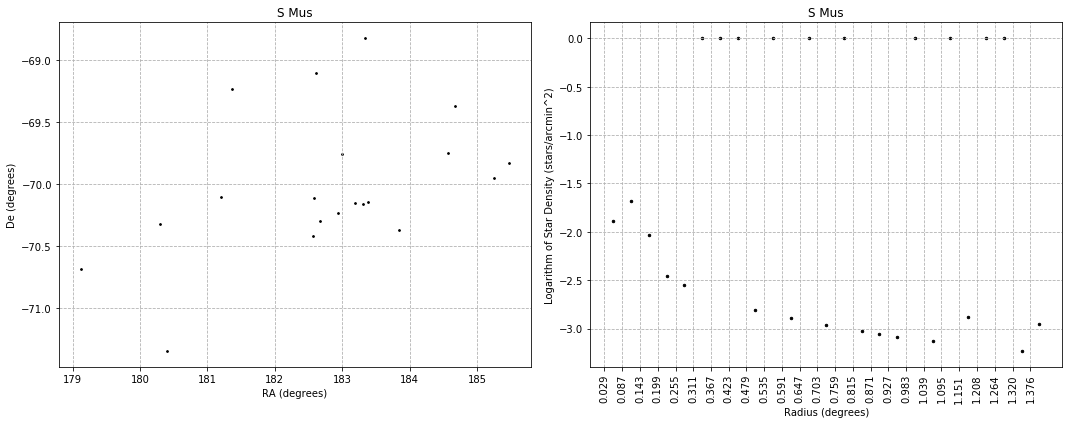

In [113]:

# Build chart scatter plot
def plot_chart(data, title):
    xs, ys = data['_RAJ2000'], data['_DEJ2000']
    plt.title(title)
    plt.xlabel('RA (degrees)')
    plt.ylabel('De (degrees)')
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

# Build RDP (Radial Density Profile) scatter plot
def plot_RDP(data, title = None):
    bins = data['_r'].value_counts(bins=25).sort_index()
    intervals = bins.index.to_tuples()
    midpoints = [i.mid for i in bins.index]
    counts = bins.values
    zipped = tuple(zip(intervals, midpoints, counts))
    densities = [count / ring_area(inner*60, outer*60) for ((inner, outer), midpoint, count) in zipped]
    log_dens = [np.log10(dens) if dens > 0 else 0 for dens in densities]
    print(bins)
    #print(intervals)
    #print(midpoints)
    #print(counts)
    #print(zipped)
    plt.grid(True, linestyle='dashed')
    plt.title(title)
    plt.xlabel('Radius (degrees)')
    plt.xticks([i for i,j in intervals], rotation='vertical')
    plt.ylabel('Logarithm of Star Density (stars/arcmin^2)')
    plt.scatter(midpoints, log_dens, s=6, color='black')

# plot both graphics side-by-side
def plot_step2(data, cl_name):
    fig = plt.figure(figsize=(15,6))
    plt.subplot(121)
    plot_chart(data, cl_name)
    plt.subplot(122)
    plot_RDP(data, cl_name)
    plt.tight_layout()

def ring_area(inner_rad, outer_rad):
    return pi * (outer_rad**2 - inner_rad**2)
    
plot_step2(df2, cl_name)


## 6 - CMD

In [ ]:
# Build G mag X Parallax scatter plot
def plot_mag_par(data, title = None):
    plxs = data['Plx']
    gmags = data['Gmag']
    min_gmag, max_gmag = mag_limits(gmags)
    min_plx, max_plx = plx_limits(plxs)
    xs, ys = gmags, plxs
    if title:
        plt.title(title)
    plt.xlabel('G (mag)')
    plt.ylabel('Plx (mas)')
    plt.xlim(min_gmag, max_gmag)
    plt.ylim(min_plx, max_plx)
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

# Build CMD (Color-Magnitude Diagram) scatter plot
def plot_CMD(data, title = None):
    gmags = data['Gmag']
    colors = data['BP-G']
    min_gmag, max_gmag = mag_limits(gmags)
    min_color, max_color = mag_limits(colors)
    xs, ys = colors, gmags
    if title:
        plt.title(title)
    plt.xlabel('BP-G (mag)')
    plt.ylabel('G (mag)')
    plt.xlim(min_color, max_color)
    plt.ylim(max_gmag, min_gmag)
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

chosen_lim_radius = 1.15 #choose one based on the RDP printed above
df3 = df2[df2['_r'] < chosen_lim_radius]
#plot_mag_par(df3, cl_name)
plot_CMD(df3, cl_name)
